In [1]:
import os
import time
import shutil
import tarfile
import pathlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import xgboost as xgb 
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, r2_score,mean_absolute_error
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import optimizers
from keras.initializers import lecun_normal
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.neural_network import MLPRegressor
import copy

Using TensorFlow backend.


In [2]:
tf.__version__

'2.1.0'

In [3]:
# CSV TO DATA
def csvToData(csv_file):
    df = pd.read_csv(csv_file, header = 0)
    column = list(df.columns.values)
    data = df.values
    return column, data

sample_column, sample_csv_data = csvToData("data/sample_submission.csv")
test_column, test_csv_data = csvToData("data/test.csv")
train_column, train_csv_data = csvToData("data/train.csv")
print('sample_submission-----------')
print(sample_column)
print(sample_csv_data.shape)
print('test-----------')
print(test_column)
print(test_csv_data.shape)
print('train-----------')
print(train_column)
print(train_csv_data.shape)


sample_submission-----------
['id', 'hhb', 'hbo2', 'ca', 'na']
(10000, 5)
test-----------
['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_src', '730_src', '740_src', '750_src', '760_src', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src', '830_src', '840_src', '850_src', '860_src', '870_src', '880_src', '890_src', '900_src', '910_src', '920_src', '930_src', '940_src', '950_src', '960_src', '970_src', '980_src', '990_src', '650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst', '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']
(10000, 72)
train-----------
['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_s

In [4]:
sample_data = pd.DataFrame(sample_csv_data, columns=sample_column)
sample_data.head()

,id,hhb,hbo2,ca,na
0,10000,0,0,0,0
1,10001,0,0,0,0
2,10002,0,0,0,0
3,10003,0,0,0,0
4,10004,0,0,0,0


In [5]:
test_data = pd.DataFrame(test_csv_data, columns=test_column)
print(test_data.shape)
test_data.head()

(10000, 72)


,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,10000.0,15.0,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,NaN,7.320236e-14
1,10001.0,15.0,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10002.0,10.0,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
3,10003.0,10.0,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,NaN
4,10004.0,25.0,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


In [6]:
train_data = pd.DataFrame(train_csv_data, columns=train_column)
print(train_data.shape)
train_data.head()

(10000, 76)


,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0.0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1.0,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2.0,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3.0,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4.0,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.97,4.41,10.78,2.42


In [7]:
src_list=['650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_src', '730_src', 
          '740_src', '750_src', '760_src', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src', 
          '830_src', '840_src', '850_src', '860_src', '870_src', '880_src', '890_src', '900_src', '910_src', 
          '920_src', '930_src', '940_src', '950_src', '960_src', '970_src', '980_src', '990_src']
dst_list=['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst', '720_dst', '730_dst', 
          '740_dst', '750_dst', '760_dst', '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', 
          '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', 
          '920_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']
rho_list=[10,15,20,25]

In [8]:
from tqdm import tqdm
alpha=train_data[dst_list]
beta=test_data[dst_list]

for i in tqdm(train_data.index):
    alpha.loc[i] = alpha.loc[i].interpolate()
    
for i in tqdm(test_data.index):
    beta.loc[i] = beta.loc[i].interpolate()
    
alpha.loc[alpha['700_dst'].isnull(),'700_dst']=alpha.loc[alpha['700_dst'].isnull(),'710_dst']
alpha.loc[alpha['690_dst'].isnull(),'690_dst']=alpha.loc[alpha['690_dst'].isnull(),'700_dst']
alpha.loc[alpha['680_dst'].isnull(),'680_dst']=alpha.loc[alpha['680_dst'].isnull(),'690_dst']
alpha.loc[alpha['670_dst'].isnull(),'670_dst']=alpha.loc[alpha['670_dst'].isnull(),'680_dst']
alpha.loc[alpha['660_dst'].isnull(),'660_dst']=alpha.loc[alpha['660_dst'].isnull(),'670_dst']
alpha.loc[alpha['650_dst'].isnull(),'650_dst']=alpha.loc[alpha['650_dst'].isnull(),'660_dst']

beta.loc[beta['700_dst'].isnull(),'700_dst']=beta.loc[beta['700_dst'].isnull(),'710_dst']
beta.loc[beta['690_dst'].isnull(),'690_dst']=beta.loc[beta['690_dst'].isnull(),'700_dst']
beta.loc[beta['680_dst'].isnull(),'680_dst']=beta.loc[beta['680_dst'].isnull(),'690_dst']
beta.loc[beta['670_dst'].isnull(),'670_dst']=beta.loc[beta['670_dst'].isnull(),'680_dst']
beta.loc[beta['660_dst'].isnull(),'660_dst']=beta.loc[beta['660_dst'].isnull(),'670_dst']
beta.loc[beta['650_dst'].isnull(),'650_dst']=beta.loc[beta['650_dst'].isnull(),'660_dst']

train_data[dst_list] = np.array(alpha)
test_data[dst_list] = np.array(beta)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2237.63it/s]


In [9]:
for col in dst_list:
    train_data[col] = train_data[col] * (train_data['rho'] ** 2)
    test_data[col] = test_data[col] * (test_data['rho']**2)

In [10]:
gap_feature_names=[]
for i in range(650, 1000, 10):
    gap_feature_names.append(str(i) + '_gap')

alpha=pd.DataFrame(np.array(train_data[src_list]) - np.array(train_data[dst_list]), columns=gap_feature_names, index=train_data.index)
beta=pd.DataFrame(np.array(test_data[src_list]) - np.array(test_data[dst_list]), columns=gap_feature_names, index=test_data.index)

train_data=pd.concat((train_data, alpha), axis=1)
test_data=pd.concat((test_data, beta), axis=1)

In [11]:
epsilon=1e-10

for dst_col, src_col in zip(dst_list, src_list):
    dst_val=train_data[dst_col]
    src_val=train_data[src_col] + epsilon
    
    delta_ratio = dst_val / src_val
    train_data[dst_col + '_' + src_col + '_ratio'] = delta_ratio
    
    dst_val=test_data[dst_col]
    src_val=test_data[src_col] + epsilon
    
    delta_ratio = dst_val / src_val
    test_data[dst_col + '_' + src_col + '_ratio'] = delta_ratio

In [12]:
alpha_real=train_data[dst_list]
alpha_imag=train_data[dst_list]

beta_real=test_data[dst_list]
beta_imag=test_data[dst_list]

for i in tqdm(alpha_real.index):
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag

    
for i in tqdm(beta_real.index):
    beta_real.loc[i]=beta_real.loc[i] - beta_real.loc[i].mean()
    beta_imag.loc[i]=beta_imag.loc[i] - beta_imag.loc[i].mean()
    
    beta_real.loc[i] = np.fft.fft(beta_real.loc[i], norm='ortho').real
    beta_imag.loc[i] = np.fft.fft(beta_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in dst_list:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

beta_real.columns=real_part
beta_imag.columns=imag_part
beta=pd.concat((beta_real, beta_imag), axis=1)

train_data=pd.concat((train_data, alpha), axis=1)
test_data=pd.concat((test_data, beta), axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 747.89it/s]


In [13]:
print(np.isnan(train_data).values.any(),np.isnan(test_data).values.any())

False False


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, r2_score
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.wrappers.scikit_learn import KerasRegressor

In [15]:
#rho 별로 분류
idx_10 = train_data['rho'] == 10
idx_15 = train_data['rho'] == 15
idx_20 = train_data['rho'] == 20
idx_25 = train_data['rho'] == 25
train_data_10 = train_data.loc[idx_10,:]
train_data_15 = train_data.loc[idx_15,:]
train_data_20 = train_data.loc[idx_20,:]
train_data_25 = train_data.loc[idx_25,:]
print(train_data_10.shape, train_data_15.shape, train_data_20.shape, train_data_25.shape)

idx_test_10 = test_data['rho'] == 10
idx_test_15 = test_data['rho'] == 15
idx_test_20 = test_data['rho'] == 20
idx_test_25 = test_data['rho'] == 25
test_data_10 = test_data.loc[idx_test_10,:]
test_data_15 = test_data.loc[idx_test_15,:]
test_data_20 = test_data.loc[idx_test_20,:]
test_data_25 = test_data.loc[idx_test_25,:]
print(test_data_10.shape, test_data_15.shape, test_data_20.shape, test_data_25.shape)

#sample Code 용 _10
x_train_sample_10 = train_data_10.loc[:, 'rho':] # train dataset
x_train_sample_10.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train_sample_10 = train_data_10.loc[:, 'hhb':'na'] # train labels
x_train_sample_10.shape, y_train_sample_10.shape
test_sample_10 = copy.deepcopy(test_data_10)

#sample Code 용 _15
x_train_sample_15 = train_data_15.loc[:, 'rho':] # train dataset
x_train_sample_15.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train_sample_15 = train_data_15.loc[:, 'hhb':'na'] # train labels
x_train_sample_15.shape, y_train_sample_15.shape
test_sample_15 = copy.deepcopy(test_data_15)

#sample Code 용 _20
x_train_sample_20 = train_data_20.loc[:, 'rho':] # train dataset
x_train_sample_20.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train_sample_20 = train_data_20.loc[:, 'hhb':'na'] # train labels
x_train_sample_20.shape, y_train_sample_20.shape
test_sample_20 = copy.deepcopy(test_data_20)

#sample Code 용 _25
x_train_sample_25 = train_data_25.loc[:, 'rho':] # train dataset
x_train_sample_25.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train_sample_25 = train_data_25.loc[:, 'hhb':'na'] # train labels
x_train_sample_25.shape, y_train_sample_25.shape
test_sample_25 = copy.deepcopy(test_data_25)

(2456, 216) (2509, 216) (2478, 216) (2557, 216)
(2519, 212) (2509, 212) (2434, 212) (2538, 212)


In [16]:
def initmodel(x_data) :
    model = Sequential()
    model.add(Dense(211, kernel_initializer='normal', activation = "relu", input_shape=(len(x_data.columns),)))
    model.add(Dense(128,  activation = "relu"))
    model.add(Dense(64,  activation = "relu"))
    model.add(Dense(32,  activation = "relu"))
    model.add(Dense(16,  activation = "relu"))
    model.add(Dense(8,  activation = "relu"))
    model.add(Dense(1))
    
    adam = optimizers.Adam(lr = 0.1, beta_1=0.9, beta_2 = 0.999, epsilon=1e-8)
    model.compile(optimizer = adam, loss = 'mse', metrics = ['mae','mse'])
    return model

In [17]:
#Sample_code
avr_valid_mse = 0
count =0
def test_train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    train_idx =0
    val_idx = 0
    for train_idx_test, val_idx_test in k_fold.split(x_data):
        train_idx = train_idx_test
        val_idx = val_idx_test

    
    model = initmodel(x_data)
    x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
    x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]
    
    
    train_history = model.fit(x_train,
                    y_train,
                    batch_size = 1,
                    validation_split = 0.2,
                    epochs = 15,
                    verbose = 1)
    
    train_model = model.predict(x_train)
    test_model = model.predict(x_val)
    
    
    
    print('train_mse : ',np.sqrt(mean_squared_error(y_train,train_model)))
    print('train_score: ',r2_score(y_train, train_model))
    valid_mse = np.sqrt(mean_absolute_error(y_val,test_model))
    global avr_valid_mse
    avr_valid_mse += valid_mse
    global count
    count += 1
    print('valid_mse : ',valid_mse)
    print('-----------------------------------------')
    models.append(model)
    
    #train_history.history.keys()
    #val_loss_lst = train_history.history['val_loss']
    #train_loss_lst = train_history.history['loss']

    #plt.figure(figsize=(12, 4))
    #plt.plot(range(0, len(val_loss_lst)), val_loss_lst, label='val_loss')
    #plt.plot(range(0, len(train_loss_lst)), train_loss_lst, label='train_loss')
    #plt.legend()
    #plt.show()
        
        

    return models
    

In [18]:
modellist = {}
test_sample = copy.deepcopy(test_data)

In [19]:
def rebuilddata (col, x_train_sample, y_train_sample, rho) :
    print(rho)
    print(col)
    if (col == 'hbo2') :
        modellist[col] = test_train_model(x_train_sample, y_train_sample[col])
        preds = []
        for model in modellist[col]:
            preds.append(model.predict(test_sample.loc[test_sample.rho==rho, 'rho':'990_dst_fft_imag']))
        pred = np.mean(preds, axis=0)
    elif col == 'hhb' :
        modellist[col] = test_train_model(x_train_sample, y_train_sample[col])
        preds = []
        for model in modellist[col]:
            preds.append(model.predict(test_sample.loc[test_sample.rho==rho, 'rho':'hbo2']))
        pred = np.mean(preds, axis=0)
    elif col == 'na' :
        modellist[col] = test_train_model(x_train_sample, y_train_sample[col])
        preds = []
        for model in modellist[col]:
            preds.append(model.predict(test_sample.loc[test_sample.rho==rho, 'rho':'hhb_hbo2_add']))
        pred = np.mean(preds, axis=0)
    elif col =='ca' :
        modellist[col] = test_train_model(x_train_sample, y_train_sample[col])
        preds = []
        for model in modellist[col]:
            preds.append(model.predict(test_sample.loc[test_sample.rho==rho, 'rho':'na']))
        pred = np.mean(preds, axis=0)
        
        
    
    test_sample.loc[test_sample.rho==rho,col] = pred[:,0]
    if rho == 10 :
        x_train_sample_10[col] = train_data_10[col] 
        return x_train_sample_10
    elif rho == 15 :
        x_train_sample_15[col] = train_data_15[col]
        return x_train_sample_15
    elif rho == 20 :
        x_train_sample_20[col] = train_data_20[col]
        return x_train_sample_20
    elif rho == 25 :
        x_train_sample_25[col] = train_data_25[col]
        return x_train_sample_25

In [20]:
for rho in rho_list :
    if rho == 10 :
        x_train_sample_10 = rebuilddata('hbo2',x_train_sample_10,y_train_sample_10,rho)
        x_train_sample_10 = rebuilddata('hhb',x_train_sample_10,y_train_sample_10,rho)
    elif rho == 15 :
        x_train_sample_15 = rebuilddata('hbo2',x_train_sample_15,y_train_sample_15,rho)
        x_train_sample_15 = rebuilddata('hhb',x_train_sample_15,y_train_sample_15,rho)
    elif rho == 20 :
        x_train_sample_20 = rebuilddata('hbo2',x_train_sample_20,y_train_sample_20,rho)
        x_train_sample_20 = rebuilddata('hhb',x_train_sample_20,y_train_sample_20,rho)
    elif rho == 25 :
        x_train_sample_25 = rebuilddata('hbo2',x_train_sample_25,y_train_sample_25,rho)
        x_train_sample_25 = rebuilddata('hhb',x_train_sample_25,y_train_sample_25,rho)

10
hbo2
Train on 1572 samples, validate on 393 samples
Epoch 1/1
1572/1572 [==============================] - 0s 230us/step - loss: 10814.9092 - mae: 11.9735 - mse: 10814.9150 - val_loss: 16.4355 - val_mae: 3.9231 - val_mse: 16.4355
train_mse :  4.06986663037501
train_score:  -16.16174411738795
valid_mse :  2.012968319339351
-----------------------------------------
10
hhb
Train on 1572 samples, validate on 393 samples
Epoch 1/1
1572/1572 [==============================] - 0s 235us/step - loss: 36315.6759 - mae: 23.6114 - mse: 36315.6797 - val_loss: 77.0794 - val_mae: 8.1967 - val_mse: 77.0794
train_mse :  9.431643143597414
train_score:  -9.239080463639722
valid_mse :  2.8130286038760164
-----------------------------------------
15
hbo2
Train on 1606 samples, validate on 402 samples
Epoch 1/1
1606/1606 [==============================] - 0s 222us/step - loss: 1598.8175 - mae: 4.4059 - mse: 1598.8173 - val_loss: 1.0636 - val_mae: 0.8274 - val_mse: 1.0636
train_mse :  1.0544588016063272
t

In [21]:
print(avr_valid_mse/count)

1.7863895074485692


In [22]:
x_train_sample = copy.deepcopy(train_data)
for rho in rho_list :
    if rho == 10 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_10.loc[:,:]
    elif rho == 15 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_15.loc[:,:]
    elif rho == 20 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_20.loc[:,:]
    elif rho == 25 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_25.loc[:,:]
        
print(x_train_sample.shape, test_sample.shape)

(10000, 216) (10000, 214)


In [23]:
train_sample_drop_na = copy.deepcopy(train_data)

train_sample_drop_na = train_sample_drop_na[train_sample_drop_na.na != 0]
x_train_sample_drop_na = train_sample_drop_na.loc[:, 'rho':] # train dataset
x_train_sample_drop_na.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train_sample_drop_na = train_sample_drop_na.loc[:, 'hhb':'na'] # train labels
x_train_sample_drop_na['hhb'] = x_train_sample['hhb']
x_train_sample_drop_na['hbo2'] = x_train_sample['hbo2']
print(x_train_sample_drop_na.shape, y_train_sample_drop_na.shape)

(9360, 213) (9360, 4)


In [24]:
#hhb, hbo2 합 = 헤모글로빈 양
gap_feature_names=[]

gap_feature_names.append('hhb_hbo2_add')

test_1=pd.DataFrame(np.array(x_train_sample['hhb']) + np.array(x_train_sample['hbo2']), columns=gap_feature_names, index=x_train_sample.index)
test_2=pd.DataFrame(np.array(x_train_sample_drop_na['hhb']) + np.array(x_train_sample_drop_na['hbo2']), columns=gap_feature_names, index=x_train_sample_drop_na.index)
test_3=pd.DataFrame(np.array(test_sample['hhb']) + np.array(test_sample['hbo2']), columns=gap_feature_names, index=test_sample.index)

test_4=pd.DataFrame(np.array(x_train_sample_10['hhb']) + np.array(x_train_sample_10['hbo2']), columns=gap_feature_names, index=x_train_sample_10.index)
test_5=pd.DataFrame(np.array(x_train_sample_15['hhb']) + np.array(x_train_sample_15['hbo2']), columns=gap_feature_names, index=x_train_sample_15.index)
test_6=pd.DataFrame(np.array(x_train_sample_20['hhb']) + np.array(x_train_sample_20['hbo2']), columns=gap_feature_names, index=x_train_sample_20.index)
test_7=pd.DataFrame(np.array(x_train_sample_25['hhb']) + np.array(x_train_sample_25['hbo2']), columns=gap_feature_names, index=x_train_sample_25.index)



x_train_sample=pd.concat((x_train_sample, test_1), axis=1)
x_train_sample_drop_na=pd.concat((x_train_sample_drop_na, test_2), axis=1)
test_sample=pd.concat((test_sample, test_3), axis=1)

x_train_sample_10=pd.concat((x_train_sample_10, test_4), axis=1)
x_train_sample_15=pd.concat((x_train_sample_15, test_5), axis=1)
x_train_sample_20=pd.concat((x_train_sample_20, test_6), axis=1)
x_train_sample_25=pd.concat((x_train_sample_25, test_7), axis=1)


In [25]:
for rho in rho_list :
    if rho == 10 :
        x_train_sample_10 = rebuilddata('na',x_train_sample_10,y_train_sample_10,rho)
        x_train_sample_10 = rebuilddata('ca',x_train_sample_10,y_train_sample_10,rho)
    elif rho == 15 :
        x_train_sample_15 = rebuilddata('na',x_train_sample_15,y_train_sample_15,rho)
        x_train_sample_15 = rebuilddata('ca',x_train_sample_15,y_train_sample_15,rho)
    elif rho == 20 :
        x_train_sample_20 = rebuilddata('na',x_train_sample_20,y_train_sample_20,rho)
        x_train_sample_20 = rebuilddata('ca',x_train_sample_20,y_train_sample_20,rho)
    elif rho == 25 :
        x_train_sample_25 = rebuilddata('na',x_train_sample_25,y_train_sample_25,rho)
        x_train_sample_25 = rebuilddata('ca',x_train_sample_25,y_train_sample_25,rho)

10
na
Train on 1572 samples, validate on 393 samples
Epoch 1/1
1572/1572 [==============================] - 0s 223us/step - loss: 1563.7264 - mae: 5.4236 - mse: 1563.7274 - val_loss: 3.6682 - val_mae: 1.5576 - val_mse: 3.6682
train_mse :  1.8993294721727587
train_score:  -6.0479911230260086e-05
valid_mse :  1.2148863766216116
-----------------------------------------


KeyError: 'hhb_hbo2_gap'

In [ ]:
value = avr_valid_mse/count
print(value)

In [ ]:
x_train_sample = copy.deepcopy(train_data)
for rho in rho_list :
    if rho == 10 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_10.loc[:,:]
    elif rho == 15 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_15.loc[:,:]
    elif rho == 20 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_20.loc[:,:]
    elif rho == 25 :
        x_train_sample.loc[x_train_sample.rho==rho,:] = x_train_sample_25.loc[:,:]
        
print(x_train_sample.shape, test_sample.shape)

In [ ]:
sample_data['hhb'] = copy.deepcopy(test_sample['hhb'])
sample_data['hbo2'] = copy.deepcopy(test_sample['hbo2'])
sample_data['ca'] = copy.deepcopy(test_sample['ca'])
sample_data['na'] = copy.deepcopy(test_sample['na'])
sample_data.head()

In [ ]:
train_hhb_mean = train_data.loc[:,'hhb'].mean(axis=0)
train_hbo2_mean = train_data.loc[:,'hbo2'].mean(axis=0)
train_ca_mean = train_data.loc[:,'ca'].mean(axis=0)
train_na_mean = train_data.loc[:,'na'].mean(axis=0)
print(train_hhb_mean, train_hbo2_mean, train_ca_mean, train_na_mean)

train_hhb_sd = train_data.loc[:,'hhb'].std(axis=0)
train_hbo2_sd = train_data.loc[:,'hbo2'].std(axis=0)
train_ca_sd = train_data.loc[:,'ca'].std(axis=0)
train_na_sd = train_data.loc[:,'na'].std(axis=0)
print(train_hhb_sd, train_hbo2_sd, train_ca_sd, train_na_sd)

sample_hhb_mean = sample_data.loc[:,'hhb'].mean(axis=0)
sample_hbo2_mean = sample_data.loc[:,'hbo2'].mean(axis=0)
sample_ca_mean = sample_data.loc[:,'ca'].mean(axis=0)
sample_na_mean = sample_data.loc[:,'na'].mean(axis=0)
print(sample_hhb_mean, sample_hbo2_mean, sample_ca_mean, sample_na_mean)

sample_hhb_sd = sample_data.loc[:,'hhb'].std(axis=0)
sample_hbo2_sd = sample_data.loc[:,'hbo2'].std(axis=0)
sample_ca_sd = sample_data.loc[:,'ca'].std(axis=0)
sample_na_sd = sample_data.loc[:,'na'].std(axis=0)
print(sample_hhb_sd, sample_hbo2_sd, sample_ca_sd, sample_na_sd)

In [ ]:

post_sample_data = copy.deepcopy(sample_data)
post_sample_data['rho'] = test_data['rho']
for col in ['hhb','hbo2','ca','na']:
    train_mean = train_data.loc[:,col].mean(axis=0)
    train_sd = train_data.loc[:,col].std(axis=0)
    sample_mean = post_sample_data.loc[:,col].mean(axis=0)
    sample_sd = post_sample_data.loc[:,col].std(axis=0)
    if col == 'na' :
        for i in range(len(post_sample_data)) :
            rho = post_sample_data.loc[i,'rho']
            if(rho == 10) :
                test_sample_sd = sample_sd * 1.2
                post_sample_data.loc[i,col] = ((post_sample_data.loc[i,col]-sample_mean)*(train_sd/test_sample_sd))+train_mean
            elif rho == 15 :
                test_sample_sd = sample_sd*0.97
                post_sample_data.loc[i,col] = ((post_sample_data.loc[i,col]-sample_mean)*(train_sd/test_sample_sd))+train_mean
            elif rho == 20 :
                test_sample_sd = sample_sd*0.7
                post_sample_data.loc[i,col] = ((post_sample_data.loc[i,col]-sample_mean)*(train_sd/test_sample_sd))+train_mean
            elif rho == 25 :
                test_sample_sd = sample_sd*0.6
                post_sample_data.loc[i,col] = ((post_sample_data.loc[i,col]-sample_mean)*(train_sd/test_sample_sd))+train_mean
            
    else :
        sample_sd = post_sample_data.loc[:,col].std(axis=0)
        post_sample_data[col] = ((post_sample_data[col]-sample_mean)*(train_sd/sample_sd))+train_mean
    
    post_sample_data[col].loc[(post_sample_data[col] < 0)] = 0

In [ ]:
sample_data.head()

In [ ]:
print(avr_valid_mse/count)

In [35]:
sample_data.to_csv('Dacon_Geonho_20200626_3.csv', index=False)

In [36]:
print('hhb')
print(train_data.loc[:,'hhb'].mean(axis=0, skipna=False))
print(post_sample_data.loc[:,'hhb'].mean(axis=0, skipna=False))
print('hbo2')
print(train_data.loc[:,'hbo2'].mean(axis=0, skipna=False))
print(post_sample_data.loc[:,'hbo2'].mean(axis=0, skipna=False))
print('ca')
print(train_data.loc[:,'ca'].mean(axis=0, skipna=False))
print(post_sample_data.loc[:,'ca'].mean(axis=0, skipna=False))
print('na')
print(train_data.loc[:,'na'].mean(axis=0, skipna=False))
print(post_sample_data.loc[:,'na'].mean(axis=0, skipna=False))

print('hhb')
print(train_data.loc[:,'hhb'].var())
print(post_sample_data.loc[:,'hhb'].var())
print('hbo2')
print(train_data.loc[:,'hbo2'].var())
print(post_sample_data.loc[:,'hbo2'].var())
print('ca')
print(train_data.loc[:,'ca'].var())
print(post_sample_data.loc[:,'ca'].var())
print('na')
print(train_data.loc[:,'na'].var())
print(post_sample_data.loc[:,'na'].var())

hhb
7.990686
8.019560800474597
hbo2
4.009146
4.009146000000007
ca
9.019226
9.019226000000014
na
3.042651
2.6393747711129816
hhb
8.825761245528485
0.025047467749701704
hbo2
0.9956616568496787
0.9956616568504125
ca
8.877141095033442
8.877141095031808
na
3.5414407862776556
3.226520258394784


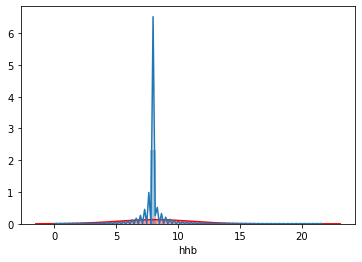

In [37]:
sns.distplot(train_data["hhb"], color = "r")
sns.distplot(post_sample_data["hhb"])

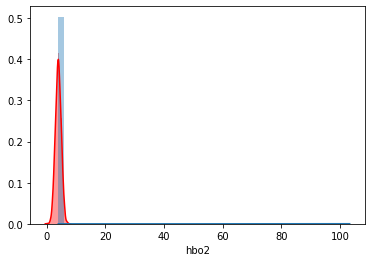

In [38]:
sns.distplot(train_data["hbo2"], color = "r")
sns.distplot(post_sample_data["hbo2"])

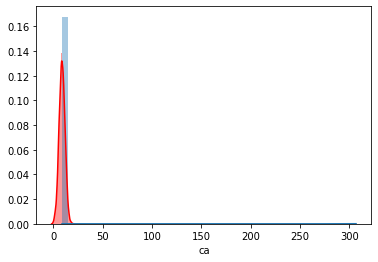

In [39]:
sns.distplot(train_data["ca"], color = "r")
sns.distplot(post_sample_data["ca"])

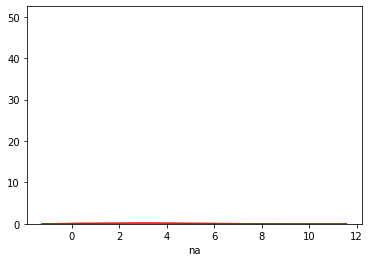

In [40]:
idx = train_data['rho'] == 10
idx_sample = post_sample_data['rho'] == 10
sns.distplot(train_data[idx]["na"], color = "r")
sns.distplot(post_sample_data[idx_sample]["na"])

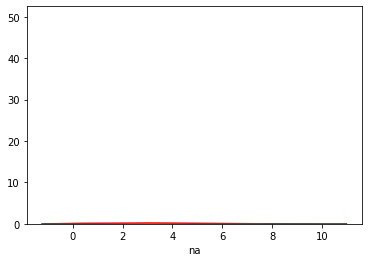

In [41]:
idx = train_data['rho'] == 15
idx_sample = post_sample_data['rho'] == 15
sns.distplot(train_data[idx]["na"], color = "r")
sns.distplot(post_sample_data[idx_sample]["na"])

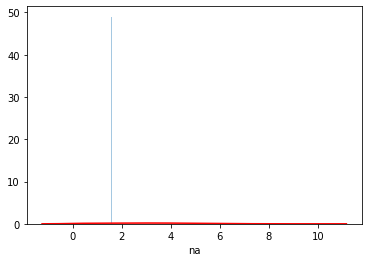

In [42]:
idx = train_data['rho'] == 20
idx_sample = post_sample_data['rho'] == 20
sns.distplot(train_data[idx]["na"], color = "r")
sns.distplot(post_sample_data[idx_sample]["na"])

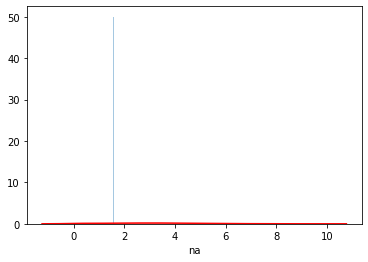

In [43]:
idx = train_data['rho'] == 25
idx_sample = post_sample_data['rho'] == 25
sns.distplot(train_data[idx]["na"], color = "r")
sns.distplot(post_sample_data[idx_sample]["na"])

In [ ]:
test_1 = copy.deepcopy(post_sample_data)
for col in modellist:
    print(col)
    if (col == 'hhb')or(col == 'hbo2') :
        preds = []
        for model in modellist[col]:
            preds.append(model.predict(xgb.DMatrix(x_train_sample.loc[:, 'rho':'990_dst_fft_imag'])))
        pred = np.mean(preds, axis=0)
        test_1[col] = pred
    else :
        preds = []
        for model in modellist[col]:
            preds.append(model.predict(xgb.DMatrix(x_train_sample.loc[:, 'rho':])))
        pred = np.mean(preds, axis=0)
        test_1[col] = pred

In [ ]:
x,y = train_data['hhb'] , test_1['hhb']
sns.regplot(x=x, y=y)

In [ ]:
x,y = train_data['hbo2'] , test_1['hbo2']
sns.regplot(x=x, y=y)

In [ ]:
x,y = train_data['ca'] , test_1['ca']
sns.regplot(x=x, y=y)

In [ ]:
x,y = train_data['na'] , test_1['na']
sns.regplot(x=x, y=y)